# Programming with the Newman-Ziff algorithm

Both bond and site percolation can be studied very efficiently using the Newman-Ziff algorithm. This experimental approach has the advantage of working for all networks of all topologies, and can be adjusted to acccount for other features that might be of interest when simulating, and to collect more statistics.

In many cases there are also theoretical solutions, where we can compute (for example) the expected size of the largest connected component without needing to do simulation at all. There is an extensive literature on this and other properties of percolating systems, and it's sometimes useful to be able to make use of these results &ndash; even if you're working in a more *ad hoc* or data-driven environment.

In this notebook we'll therefore do two things. We'll use `epydemic`'s built-in Newman-Ziff experiment to look for the percolation threshold for a network having a powerlaw-with-cutoff degree distribution. But there is a theoretical result that allows us to *compute* this threshold directly from the degree distribution. Deriving this value uses some fairly invovled mathematics, but *once we have the final expressions* we can make use of them to validate our experiments, by coding-up the equations in Python and solving them numerically. This is what we'll do here, to show how to match highly mathematical results with simulations.

In [1]:
from epyc import Lab, Experiment, LabNotebook, JSONLabNotebook
from epydemic import BondPercolation, SitePercolation, PLCNetwork

# maths
from math import exp
from mpmath import polylog as Li

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

In [2]:
# create a lab notebook backed by a JSON file
nb = JSONLabNotebook(Path(datasets, "08a-08-nz.json"))

There's no point in looking for much paralellism as Newman-Ziff is a sequential algorithm. However, we'll be doing calculations for three different-sized networks, which we can run in parallel.

In [60]:
nCores = 3
lab = ParallelLab(notebook=nb, cores=nCores)

## Site percolation

We will reproduce figure 13 of [[NZ00]](#NZ00). This computes the site percolation behaviour on a network of $10^6$ nodes with a powerlaw-with-cutoff degree distribution, for three different cutoff values $\kappa$.

The computation involves running the site percolation experiment over networks with different cutoff values. 

In [5]:
def nz_site(lab):
    # set up the network parameter space
    lab[PLCNetwork.N] = int(1e6)
    lab[PLCNetwork.EXPONENT] = 2.5
    lab[PLCNetwork.CUTOFF] = [20, 50, 100]

    # run the experiment over the parameter space
    e = SitePercolation(PLCNetwork())
    lab.runExperiment(e)

You can examine the code for the `SitePercolation` class in `epydemic`'s codebase. It essentially codes-up the algorithm we explored earlier (there's also a `BondPercolation` class), and has several places where you can extend or override methods to provide different features, collect more statistics, and so forth.

In [6]:
lab.createWith("nz_threshold_plc",
               nz_site,
               "Site percolation on PLC networks")

True

## Theoretical sizes of the largest components

We need to compare these results with the known theoretical predictions for percolation. Callaway *et alia* [[CNSW00]](#CNSW00) derived the necessary equations for the size $S$ of the giant component at a specific value of $\phi$.

It's obviously very useful to understand the derivation of these results. However, no-one knows everything, and that's nowhere more true than for complex systems, where there is a huge range of techniques on offer. It's useful to develop the skill of making use of results, even if you only broadly understand their derivation. While a purist would argue that this is a dangerous approach &ndash; and they'd be right &ndash; practicing scientists have to live in a reality whereby they take and use the techniques that are available.

We compute the value of $S$ using the degree distribtuion of the network given by a sequence of values $p_k$, the probability of a random node having degree $k$ &ndash; or, alternatively, the fraction of nodes having this degree. They use this to build a generating function:

$$
F_0(x) = \sum_{k = 0}^\infty p_k \phi x^k
$$

where $p_k \phi$ is the probability of a node having degree $k$ and being occupied. They then construct another generating function defining the degree of neighbouring nodes, the so-called *excess degree*:

$$
F_1(x) = \frac{\sum_{k = 0}^\infty k p_k \phi x^{k - 1}}{\sum_{k = 1}^\infty k p_k}
$$

Notice that these equations are just functions of the basic degree distribution, which is all we need to know in order to compute them &ndash; and that we can either use to create the network of interest (if it's random) or measure from it (if it's a real-world network).

From here, $S$ is defined in terms of an auxiliary value $u$ representing the relationship between degree distribution and excess degree:

\begin{align*}
u &= 1 - F_1(1) + F_1(u) \\
  &= 1 - \phi - \phi \frac{\sum_{k=0}^{\infty} k p_k u^{k - 1}}{\sum_{k=0}^{\infty}k p_k}
\end{align*}

Then:

\begin{align*}
S  &= F_0(1) - F_1(u) \\
   &= \phi - \phi \sum_{k=0}^{\infty} p_k u^k 
\end{align*}

### Computing with the equations

These are quite complicated equations &ndash; especially the one for $u$, which is actually a self-consistency condition where $u$ is defined in terms of itself. It might not be obvious how to proceed, but in fact there is a straightforward approach we can use.

First we define the two functions in Python.

In [18]:
def S(u, p, phi, maxk=100):
    s = 0
    for k in range(1, maxk):
        s += p(k) * pow(u, k)
    return phi * (1 - s)

def u(u, p, phi, maxk=100):
    s = 0
    t = 0
    for k in range(1, maxk):
        s += k * p(k) * pow(u, k - 1)
        t += k * p(k)
    return 1 - phi + phi * s / t

We expect a function `p` that defines the values of $p_k$ for each degree $k$, a value for $u$, an occupation probability, and a maximum degree for the network of interest. Notice that the definition of `u` is passed a value of `u`, reflecting the self-consistency. How do we get this value? We make use of fixed-point iteration to evalute the function and find its fixed-point.

In [19]:
def fix(f, x=0.0, delta=1e-6, maxreps=50):
    '''Perform naive fixed-point iteration on the given function.
    
    :param f: the function (of one variable)
    :param x: (optional) the starting point (defaults to 0.0)
    :param delta: (optional) the stopping distance (defauls to 1e-6)
    :param maxreps: (optional) maximum number of steps (defaults to 50)
    :returns: the converged value of x'''
    for _ in range(maxreps):
        xprime = f(x)
        if abs(x - xprime) < delta:
            return xprime
        x = xprime
    return x

And once we have a value for $u$ we can simply plug it into the function `S` to obtain the theoretical component size.

In [20]:
def gcc_theoretical(p, phi):
    '''Compute the theoretical size of the giant connected component.
    
    :param p: the degree distribution
    :param phi: the occupation probability
    :returns: the predicted size of the GCC as a fraction of the network size'''
    u_fix = fix(lambda x: u(x, p, phi))
    return S(u_fix, p, phi)

(We wrapped `u` up in a lambda-expression to let us compute the fixpoint with respect to $u$ alone, since the other parameters are fixed.)

## Comparing theory and practice

The experiment we conducted involved a powerlaw-with-cutoff network of $10^6$ nodes. We need to know the degree distrioution for this network: we could just count the values, but the degree distribtuion is known, as we've seen elsewhere:

$$
    p_k = \frac{1}{C} k^{-\alpha} e^{-k / \kappa}
$$

where $C = Li_\alpha(e^{-1 / \kappa})$ is a constant of proportionality derived from the polylogarithm function. We can code this distribution very simply.

In [22]:
def make_PLC(alpha, kappa):
    '''Create a powerlaw-with-cutoff probability distribution for the given parameters.
    
    :param alpha: the exponent
    :param kappa: the cutoff'''
    C = Li(alpha, exp(-1.0 / kappa))
    def p(k):
        return (pow(k, -alpha) * exp(-k / kappa)) / C
    return p

We now have everything we need to plot our experimental results against the theoretical results obtained in the paper.

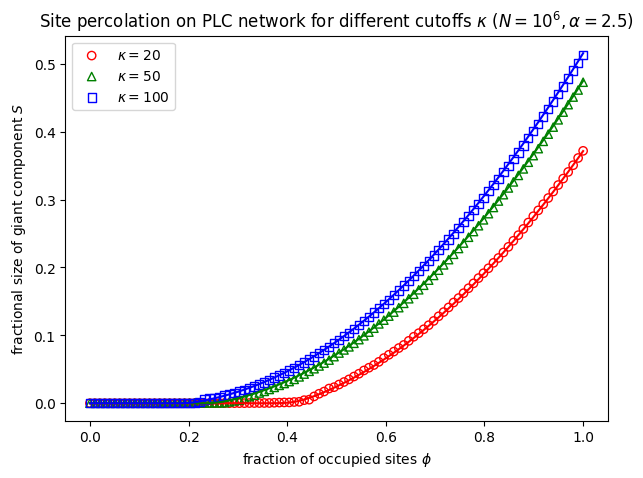

In [59]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

N = df[PLCNetwork.N].max()
alpha = df[PLCNetwork.EXPONENT].max()
kappas = sorted(df[PLCNetwork.CUTOFF].unique())

kappa_colours = ['r', 'g', 'b']
kappa_markers = ['o', '^', 's']

gccs = dict()
for i in range(len(kappas)):
    kappa = kappas[i]
    kdf = df[df[PLCNetwork.CUTOFF] == kappa]
    ps = kdf[SitePercolation.P].iloc[0]
    
    # theory
    p = make_PLC(alpha, kappa)
    gccs[kappa] = list(map(lambda phi: 0.0 if phi == 0.0 else gcc_theoretical(p, phi), ps))
    ax.plot(ps, gccs[kappa],
            '{c}-'.format(c=kappa_colours[i]))
    
    # experiment
    lccs = list(kdf[SitePercolation.GCC].iloc[0] / N)
    ax.scatter(ps, lccs,
               color='none', edgecolors=kappa_colours[i], marker=kappa_markers[i],
               label=f'$\kappa = {kappa}$')

ax.set_xlabel('fraction of occupied sites $\phi$')
ax.set_ylabel('fractional size of giant component $S$')
ax.legend(loc='upper left')
ax.set_title('Site percolation on PLC network for different cutoffs $\kappa$ ($N = 10^6, \\alpha = 2.5$)')

_ = plt.show()

How long does the process take?

In [57]:
for kappa in kappas:
    kdf = df[df[PLCNetwork.CUTOFF] == kappa]
    gen = kdf[Experiment.SETUP_TIME].mean()
    per = kdf[Experiment.EXPERIMENT_TIME].mean()
    print(f'kappa = {kappa}, network creation {gen:.0f}s, percolation process {per:.0f}s')

kappa = 20, network creation 1571s, percolation process 6s
kappa = 50, network creation 1508s, percolation process 7s
kappa = 100, network creation 1557s, percolation process 8s


Newman and Ziff comment that generating the above plot took "about an hour in total". For comparison -- 20 years later, and coded in Python rather than C -- the three processes in the above figure take under half a minute to compute -- *if* we ignore network-creation time, which takes half an hour for each cutoff. (It actually takes longer to numerically approximate the curves of the theoretical model than it does to run the experiment.)

## References

<a id='CNSW00'>[CNSW00]</a> Duncan Callaway, M.E.J. Newman, Steven Strogatz, and Duncan Watts. [Network robustness and fragility: Percolation on random graphs](https://doi.org/10.1103/PhysRevLett.85.5468). Physical Review Letters **85**. 2000.

<a id='NZ00'>[NZ00]</a> M.E.J. Newman and R.M. Ziff. [Efficient Monte Carlo algorithm and high-precision results for percolation](https://doi.org/10.1103/PhysRevLett.85.4104>). Physical Review Letters **85**. November 2000.
